# Preparation

In [1]:
import iminuit
%load_ext line_profiler
import matplotlib.pyplot as plt
%matplotlib inline
import numba
import numpy as np
import pandas as pd
import scipy as sp
from scipy import optimize
import seaborn as sns

sns.set_style('darkgrid')
sns.set_context('notebook')

%load_ext watermark
%watermark
%watermark -p pandas,scipy

2018-09-04T15:45:32+02:00

CPython 3.6.6
IPython 6.5.0

compiler   : GCC 4.8.2 20140120 (Red Hat 4.8.2-15)
system     : Linux
release    : 4.4.138-59-default
machine    : x86_64
processor  : x86_64
CPU cores  : 16
interpreter: 64bit
pandas 0.23.4
scipy 1.1.0


In [2]:
results = pd.DataFrame()

# Load C14 models

In [3]:
import c14_models

# Read patient data

In [4]:
c14_patient_data = pd.read_pickle('../../results/C14data_liver_samples_20180505.pkl')

In [5]:
c14_patient_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,valid
0,unsorted,PH1,ND380,1942.833333,2016.416667,0.078416,0.003981,NaN,N,73.583333,True
1,unsorted,PH2,ND388,1991.416667,2016.833333,0.025254,0.003912,NaN,N,25.416667,True
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,True


In [6]:
exp_data = c14_patient_data.query('valid and type in ["hepatocyte", "hepatocyte 2n", "hepatocyte 4n"]').copy()
exp_data.head()

,type,code,sample,Dbirth,Dcoll,d14C,error_measurement,N_cells,pathology,subject_age,valid
2,hepatocyte,PH3,ND381,1985.166667,2016.416667,0.040336,0.008788,58.0,N,31.250000,True
3,hepatocyte,PH4,ND382,1982.083333,2016.500000,0.018815,0.005342,52.0,N,34.416667,True
4,hepatocyte,PH6,ND022,1946.500000,2004.833333,0.075001,0.004711,62.0,N,58.333333,True
5,hepatocyte,PH7,ND023,1945.833333,2004.833333,0.090351,0.004395,70.0,N,59.000000,True
6,hepatocyte,PH9,ND383,1937.583333,2016.666667,0.041243,0.004284,66.0,Y,79.083333,True


In [7]:
exp_data.describe()

,Dbirth,Dcoll,d14C,error_measurement,N_cells,subject_age
count,33.000000,33.000000,33.000000,33.000000,33.000000,33.000000
mean,1962.171717,2016.330808,0.038511,0.006863,72.651515,54.159091
std,20.123360,2.990471,0.018763,0.002568,27.201931,19.753333
min,1932.583333,2004.833333,0.005100,0.004050,21.500000,20.000000
25%,1945.833333,2016.666667,0.027700,0.004650,56.000000,36.000000
50%,1959.333333,2017.166667,0.032800,0.005350,67.000000,58.166667
75%,1980.416667,2017.416667,0.046900,0.009000,96.000000,69.333333
max,1997.333333,2017.500000,0.090351,0.011659,129.000000,84.583333


# SSE & log-likelihood

In [8]:
def SSE(p, model, data):
    model_data = model(data['Dbirth'].values, 
                    data['Dcoll'].values, 
                    *p)
    sse = np.sum((model_data - data['d14C'].values)**2)
    return sse    

In [9]:
def Sigma(p, model, data):
    sse = SSE(p, model, data)
    n = len(data)
    sigma = np.sqrt(sse/n)
    return sigma

In [10]:
def Nloglike(p, model, data):
    try:
        sse = SSE(p, model, data)
    except:
        sse = SSE([p], model, data)
    n = len(data)
    sig = np.sqrt(sse/n)
    loglike = -n/2 * np.log(2*np.pi) - n/2 * np.log(sig**2) - 1 / (2*sig**2) * sse
    return -loglike

# Scenario I1

In [11]:
@np.vectorize
def I1(Dbirth, Dcoll, loglam):
    lam = np.exp(loglam)
    return c14_models.I1c(Dbirth, Dcoll, lam)

## Fit

In [12]:
res_I1 = sp.optimize.minimize(fun=Nloglike, 
                     x0=[-1.0],
                     args = (I1, exp_data),
                    )

In [13]:
res_I1

      fun: -91.94570594439332
 hess_inv: array([[0.00972291]])
      jac: array([-3.81469727e-06])
  message: 'Optimization terminated successfully.'
     nfev: 30
      nit: 7
     njev: 10
   status: 0
  success: True
        x: array([-1.58672568])

## Result

In [14]:
print('lambda', sp.exp(res_I1.x[0]))

print('sigma', Sigma(res_I1.x, I1, exp_data))

results.loc['I1', 'loglike'] = -res_I1.fun
results.loc['I1', 'k'] = 2
results.loc['I1', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lambda 0.20459442334703945
sigma 0.014918219218309306


,loglike,k,n,cAIC
I1,91.945706,2.0,33.0,-179.491412


In [15]:
print('Average measurement error: {:.3f}'.format(exp_data['error_measurement'].mean()))

Average measurement error: 0.007


# I1 Memory

In [16]:
@np.vectorize
def I1_memory(Dbirth, Dcoll, loglam, f, t0):
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    
    if t0>Dcoll-Dbirth:
        return C1
    else:
        C0 = c14_models.I1c(Dbirth, Dbirth + t0, lam)
        return f*C1 + (1-f)*C0

## Fit

In [17]:
res_I1_memory = sp.optimize.minimize(fun=Nloglike, 
                     x0=[np.log(0.2), 0.8, 20.0],
                     args = (I1_memory, exp_data),
                                     method='Nelder-Mead'
                    )

## Result

In [18]:
print('lambda', sp.exp(res_I1_memory.x[0]))
print('f', res_I1_memory.x[1])
print('t0', res_I1_memory.x[2])

print('sigma', Sigma(res_I1_memory.x, I1_memory, exp_data))

results.loc['I1_memory', 'loglike'] = -res_I1_memory.fun
results.loc['I1_memory', 'k'] = 4
results.loc['I1_memory', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lambda 0.2763260922208169
f 0.9704473525084147
t0 30.29446649020982
sigma 0.013940918968818303


,loglike,k,n,cAIC
I1,91.945706,2.0,33.0,-179.491412
I1_memory,94.181618,4.0,33.0,-178.934664


## Plot

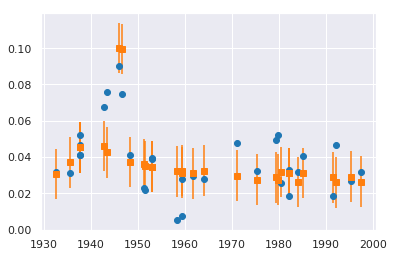

In [19]:
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls='None', marker='o')

plt.errorbar(exp_data['Dbirth'], 
             I1_memory(exp_data['Dbirth'], 
                      exp_data['Dcoll'],
                      *res_I1_memory.x),
             Sigma(res_I1_memory.x, I1_memory, exp_data),
             ls = 'None', marker='s')

plt.show()

# I1 Memory Interval

In [33]:
Dbirth = 1950.
t0 = 10.
lam = 0.1

In [74]:
@np.vectorize
def I1_memory_interval(Dbirth, Dcoll, loglam, f, t0, t1):
    if f >= 1:
        f = 1
    if t0 < 0.1:
        t0 = 0.1
    if t1 < 0.1:
        t1 = 0.1
    lam = np.exp(loglam)
    C1 = c14_models.I1c(Dbirth, Dcoll, lam)
    C0 = C1
    
    if Dbirth + t0 >= Dcoll:
        C0 = C1
    elif Dbirth + t0 + t1 >= Dcoll:
        C0 = np.mean(np.vectorize(c14_models.I1c)(Dbirth, np.arange(Dbirth + t0, Dcoll, 1), lam))
    else:
        C0 = np.mean(np.vectorize(c14_models.I1c)(Dbirth, np.arange(Dbirth + t0, Dbirth + t0 + t1, 1), lam))
    return f*C1 + (1-f)*C0

## Fit

In [84]:
res_I1_memory_interval = sp.optimize.minimize(fun=Nloglike, 
                     x0=[np.log(0.2), 0.95, 30.0, 1.0],
                     args = (I1_memory_interval, exp_data),
                                     method='Nelder-Mead'
                    )

## Result

In [85]:
print('lambda', sp.exp(res_I1_memory_interval.x[0]))
print('f', res_I1_memory_interval.x[1])
print('t0', res_I1_memory_interval.x[2])
print('t1', res_I1_memory_interval.x[3])

print('sigma', Sigma(res_I1_memory_interval.x, I1_memory_interval, exp_data))

results.loc['I1_memory_interval', 'loglike'] = -res_I1_memory_interval.fun
results.loc['I1_memory_interval', 'k'] = 5
results.loc['I1_memory_interval', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

lambda 0.2760000432033002
f 0.9705708432165858
t0 30.300342325426012
t1 0.9985086217746975
sigma 0.0139409162976819


,loglike,k,n,cAIC
I1,91.945706,2.0,33.0,-179.491412
I1_memory,94.181618,4.0,33.0,-178.934664
I1_memory_interval,94.181624,5.0,33.0,-176.141026


## Plot

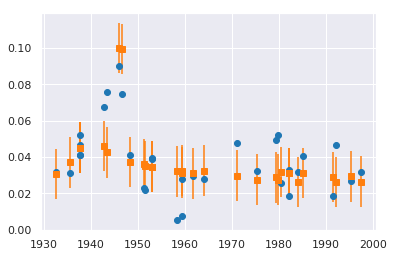

In [86]:
plt.plot(exp_data['Dbirth'], exp_data['d14C'], ls='None', marker='o')

plt.errorbar(exp_data['Dbirth'], 
             I1_memory_interval(exp_data['Dbirth'], 
                      exp_data['Dcoll'],
                      *res_I1_memory_interval.x),
             Sigma(res_I1_memory_interval.x, I1_memory_interval, exp_data),
             ls = 'None', marker='s')

plt.show()

# I1T_step

In [ ]:
I1T = c14_models.I1T

In [ ]:
@np.vectorize
def I1T_step(Dbirth, Dcoll, loglam1, loglam2, t_step):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_step(t, lam1, lam2, t_step):
        return np.where(t < Dbirth + t_step, lam1, lam2)
    
    return I1T(Dbirth, Dcoll, lam_step, t_eval=np.linspace(Dbirth, Dcoll), lam_arg=(lam1, lam2, t_step))[1][-1]

## Fit

In [ ]:
res_I1T_step = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2, -1, 30.0],
                           args = (I1T_step, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [ ]:
print('lambda1', np.exp(res_I1T_step.x[0]))
print('lambda2', np.exp(res_I1T_step.x[1]))
print('t_step', res_I1T_step.x[2])

print('sigma', Sigma(res_I1T_step.x, I1T_step, exp_data))

results.loc['I1T_step', 'loglike'] = -res_I1T_step.fun
results.loc['I1T_step', 'k'] = 4
results.loc['I1T_step', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# I1T_transient

In [ ]:
@np.vectorize
def I1T_transient(Dbirth, Dcoll, loglam1, loglam2, t_on, t_off):
    lam1 = np.exp(loglam1)
    lam2 = np.exp(loglam2)
    
    def lam_transient(t, lam1, lam2, t_on, t_off):
        return np.where(np.logical_or(t < Dbirth + t_on,
                                      t > Dbirth + t_on + t_off),
                        lam1, 
                        lam2)
    
    return I1T(Dbirth, Dcoll, lam_transient, 
               t_eval=np.linspace(Dbirth, Dcoll), 
               lam_arg=(lam1, lam2, t_on, t_off)
              )[1][-1]

## Fit

In [ ]:
res_I1T_transient = sp.optimize.minimize(fun=Nloglike, 
                           x0=[-2.0, -3.0, 60.0, 70],
                           args = (I1T_transient, exp_data),
                           method="Nelder-Mead"
                          )

## Result

In [ ]:
print('lambda1', np.exp(res_I1T_transient.x[0]))
print('lambda2', np.exp(res_I1T_transient.x[1]))
print('t_on', res_I1T_transient.x[2])
print('t_off', res_I1T_transient.x[3])

sig = Sigma(res_I1T_transient.x, I1T_transient, exp_data)
print('sigma', sig)

results.loc['I1T_transient', 'loglike'] = -res_I1T_transient.fun
results.loc['I1T_transient', 'k'] = 5
results.loc['I1T_transient', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# Plot I1, I1T, I1_memory

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
tt = np.linspace(1930, 2010)
ax.plot(tt, np.vectorize(c14_models.C_atm)(tt))
ax.plot(exp_data['Dbirth'], exp_data['d14C'], ls = 'None', marker = 'o')

ax.errorbar(exp_data['Dbirth']-0.4, 
            I1(exp_data['Dbirth'].values,
               exp_data['Dcoll'].values,
               *res_I1.x
               ),
           Sigma(res_I1.x, I1, exp_data),
           ls='None',
           label = 'I1')

ax.errorbar(exp_data['Dbirth'], 
            I1T_transient(exp_data['Dbirth'].values,
                          exp_data['Dcoll'].values,
                          *res_I1T_transient.x
                         ),
           Sigma(res_I1T_transient.x, I1T_transient, exp_data),
           ls='None',
            marker='s',
           label = 'I1T_transient')

ax.errorbar(exp_data['Dbirth']+0.4, 
             I1_memory(exp_data['Dbirth'], 
                      exp_data['Dcoll'],
                      *res_I1_memory.x),
             Sigma(res_I1_memory.x, I1_memory, exp_data),
             ls = 'None',
            marker='o',
           label='I1_memory')


ax.set_ylim((0, 0.12))
ax.legend()
plt.show()

# IK

In [ ]:
@np.vectorize
def IK(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IK(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-1.5, 1), (0.2, 0.95)],
                  args = (IK, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

In [ ]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [ ]:
lam = sp.exp(res[0][0])
print('lambda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IK, exp_data)
print('sigma', sig)

results.loc['IK', 'loglike'] = -res[1]
results.loc['IK', 'k'] = 3
results.loc['IK', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# IL

In [ ]:
@np.vectorize
def IL(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.IL(Dbirth, Dcoll, lam, f, t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-2, 2), (0.01, 0.99)],
                  args = (IL, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

In [ ]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z, vmax=8)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

## Result

In [ ]:
lam = sp.exp(res[0][0])
print('lambda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], IL, exp_data)
print('sigma', sig)

results.loc['IL', 'loglike'] = -res[1]
results.loc['IL', 'k'] = 3
results.loc['IL', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# I2

In [ ]:
@np.vectorize
def I2(Dbirth, Dcoll, loglam, f):
    lam = np.exp(loglam)
    return c14_models.I2(Dbirth, Dcoll, lam, f, 
                         t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(-3, 0.5), (0.85, 1)],
                  args = (I2, exp_data),
                  Ns = 20,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

In [ ]:
x = res[2][0]
y = res[2][1]
z = res[3]
z -= z.min()

CS = plt.contour(x, y, z)
plt.pcolormesh(x, y, z)

plt.clabel(CS, inline=1, fontsize=10)

plt.xlabel('loglam')
plt.ylabel('f')
plt.colorbar()

plt.show()

In [ ]:
lam = sp.exp(res[0][0])
print('lambda', lam)

f = res[0][1]
print('f', f)

sig = Sigma([np.log(lam), f], I2, exp_data)
print('sigma', sig)

results.loc['I2', 'loglike'] = -res[1]
results.loc['I2', 'k'] = 3
results.loc['I2', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# Scenario IX2p

In [ ]:
@np.vectorize
def IX2p(Dbirth, Dcoll, dloglam1, dloglam2, f1):
    dlam1 = np.exp(dloglam1)
    dlam2 = np.exp(dloglam2)
    
    f2 = 1-f1
    
    return c14_models.IX(Dbirth, Dcoll, [dlam1, dlam2], [f1, f2],
                        t_eval=np.linspace(Dbirth, Dcoll))[1][-1]

## Fit

In [ ]:
res = sp.optimize.brute(func=Nloglike, 
                  ranges=[(np.log(0.01), np.log(2.0)),(np.log(0.01), np.log(2.0)) , (0, 1)],
                  args = (IX2p, exp_data),
                  Ns = 10,
                  full_output = True,
                  finish=None)

print(res[0])
print(res[1])

## Result

In [ ]:
results.loc['IX2p', 'loglike'] = -res[1]
results.loc['IX2p', 'k'] = 4
results.loc['IX2p', 'n'] = len(exp_data)

results['cAIC'] = 2 * results['k'] - 2 * results['loglike'] + (2*results['k']**2 + 2*results['k'])/(results['n']-results['k']-1)

results

# Results

In [ ]:
results.sort_values('cAIC')